# This notebook shows the steps in training and evaluating a CNN with hidden layers. I have tried three different models with different complexcity. But the accuracy scores were not better than MultinomialNB and SGDclasifier.

In [66]:
import pandas as pd
import matplotlib as plt
import string
import nltk
import re
import unicodedata
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer

In [67]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nalindakulathunga/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [68]:
filenames = ['amazon_cells_labelled.txt', 'imdb_labelled.txt', 'yelp_labelled.txt']
with open('combined_reviews.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            outfile.write(infile.read())
            
Combined_DF = pd.read_csv("combined_reviews.txt", sep='\t', names = ["Review", "Label"])
Combined_DF = Combined_DF.sample(frac=1).reset_index(drop=True)

In [69]:
print Combined_DF.head(10)

                                              Review  Label
0  Not much dialogue, not much music, the whole f...      1
1  Unfortunately, 'Cover Girl' is an example of h...      0
2  Emily Watson's character is very strong, and s...      1
3            I'd rather eat airline food, seriously.      0
4  It features an outlandish array of memorable, ...      1
5  The food was outstanding and the prices were v...      1
6             The service was not up to par, either.      0
7  It has northern humour and positive about the ...      1
8                                        Worst ever.      0
9            I had a seriously solid breakfast here.      1


In [70]:
Combined_Df_RW = Combined_DF.drop('Label', axis=1)
Combined_Df_LB = Combined_DF["Label"]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(Combined_Df_RW, Combined_Df_LB, test_size=0.33, random_state=42)

In [72]:
print len(X_train)

1841


In [73]:
print len(X_test)

907


In [74]:
def strip_accents(text):
    """
    Remove accents from input String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

def text_to_id(text):
    """
    Convert input text to id.
    """
    text = strip_accents(text.lower())
    text = re.sub('[ ]+', '_', text)
    text = re.sub('[^0-9a-zA-Z_-]', '', text)
    return text

In [75]:
def PreProcess(InList = []):
    X_List_nopunc = [''.join(c for c in s if c not in string.punctuation) for s in InList]
    X_List_nopunc_noempty = [s for s in X_List_nopunc if s]
    X_List_nopunc_noempty_nocaps = [x.lower() for x in X_List_nopunc_noempty]
    
    sent_list = []

    count = 0
    for item in range(len(InList)):
        count += 1
        word_string = ""
        for word in X_List_nopunc_noempty_nocaps[item][:].split(): 
            word_str = text_to_id(word)
            new_word = WordNetLemmatizer().lemmatize(word_str, 'v')
            word_string += str(new_word) + " "
        if word_string != "":
            sent_list.append(word_string)
    
    return sent_list

In [76]:
X_train_List = X_train["Review"].tolist()
X_train_List_cleaned = PreProcess(X_train_List)

X_test_List = X_test["Review"].tolist()
X_test_List_cleaned = PreProcess(X_test_List)

In [77]:
print X_train_List_cleaned[:10]

['please dont waste your money ', 'what happen next be prettyoff put ', 'who in their right mind be gonna buy this battery ', 'service be quick and friendly ', 'hawaiian breeze mango magic and pineapple delight be the smoothies that ive try so far and theyre all good ', 'i love the fact that everything on their menu be worth it ', 'when i open the sandwich i be impress but not in a good way ', 'and consider the two of us leave there very full and happy for about 20 you just cant go wrong ', 'this pair of headphones be the worst that i have ever have soundwise ', 'ive live here since 1979 and this be the first and last time ive step foot into this place ']


In [78]:
print X_test_List_cleaned[:10]

['first off the reception suck i have never have more than 2 bar ever ', 'angus scrimm also turn in a good performance in a somewhat brief but memorable role as the gently menace violinplaying anatomist doctor quinn ', 'however after see the short again after about 25 years i be amaze at how timeless the film actually be ', 'great food for the price which be very high quality and house make ', 'for that price i can think of a few place i would have much rather go ', 'for a self proclaim coffee cafe i be wildly disappoint ', 'ive drop my phone more time than i can say even on concrete and my phone be still great knock on wood ', 'wont ever go here again ', 'she carry the movie well ', 'this place deserve one star and 90 have to do with the food ']


In [79]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
  
def StopWordsRemove(InList):
    stop_words = set(stopwords.words('english'))
    OutList = []
    for item in InList:
        word_tokens = word_tokenize(item)
        sent_WO_stop = [w for w in word_tokens if not w in stop_words]
        sent_WO_stop = ""
    
        for w in word_tokens:
            if w not in stop_words:
                sent_WO_stop += w
                sent_WO_stop += " "
            
        OutList.append(sent_WO_stop)
    return OutList

In [80]:
X_train_List_F = StopWordsRemove(X_train_List_cleaned)
X_test_List_F = StopWordsRemove(X_test_List_cleaned)

In [81]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

from keras.layers import Dropout
from keras.layers import Convolution1D

In [82]:
# integer encode the documents
vocab_size = 4000
encoded_docs = [one_hot(d, vocab_size) for d in X_train_List_F]
#print(encoded_docs)

In [83]:
# pad documents to a max length of 4 words
max_length = 200
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
#for item in padded_docs:
    #print(item)
    #print "\n"

In [85]:
############## __model_01__ ##################
#model = Sequential()
#model.add(Embedding(vocab_size, 100, input_length=max_length))
#model.add(Flatten())
#model.add(Dense(1, activation='sigmoid'))
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
#print(model.summary())
#############################################

############## __model_02__ ##################
#model = Sequential()
#model.add(Embedding(vocab_size, max_length, input_length=max_length))
#model.add(Convolution1D(64, 3, border_mode='same'))
#model.add(Convolution1D(32, 3, border_mode='same'))
#model.add(Flatten())
#model.add(Dropout(0.2))
#model.add(Dense(180,activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(1,activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#print(model.summary())
#############################################

############## __model_03__ ##################
model = Sequential()
model.add(Embedding(vocab_size, max_length, input_length=max_length))
model.add(Convolution1D(64, 3, border_mode='same'))
model.add(Convolution1D(32, 3, border_mode='same'))
model.add(Convolution1D(16, 3, border_mode='same'))
model.add(Convolution1D(8, 3, border_mode='same'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(180,activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#############################################



/Users/nalindakulathunga/.local/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 3, padding="same")`
/Users/nalindakulathunga/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(32, 3, padding="same")`
/Users/nalindakulathunga/.local/lib/python2.7/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(16, 3, padding="same")`
/Users/nalindakulathunga/.local/lib/python2.7/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(8, 3, padding="same")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 200)          800000    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 200, 64)           38464     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 200, 32)           6176      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 200, 16)           1552      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 200, 8)            392       
_________________________________________________________________
flatten_7 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1600)              0         
__________

In [86]:
model.fit(padded_docs, y_train, epochs=10, verbose=1)

Epoch 1/10
1841/1841 [==============================] - 5s - loss: 0.7038 - acc: 0.4883     
Epoch 2/10
1841/1841 [==============================] - 4s - loss: 0.7020 - acc: 0.4981     
Epoch 3/10
1841/1841 [==============================] - 4s - loss: 0.5730 - acc: 0.6741     
Epoch 4/10
1841/1841 [==============================] - 4s - loss: 0.3013 - acc: 0.8751     
Epoch 5/10
1841/1841 [==============================] - 4s - loss: 0.1750 - acc: 0.9348     
Epoch 6/10
1841/1841 [==============================] - 4s - loss: 0.1075 - acc: 0.9614     
Epoch 7/10
1841/1841 [==============================] - 4s - loss: 0.0689 - acc: 0.9783     
Epoch 8/10
1841/1841 [==============================] - 4s - loss: 0.0579 - acc: 0.9832     
Epoch 9/10
1841/1841 [==============================] - 4s - loss: 0.0462 - acc: 0.9880     
Epoch 10/10
1841/1841 [==============================] - 4s - loss: 0.0415 - acc: 0.9880     


In [87]:
vocab_size = 4000
encoded_docs_test = [one_hot(d, vocab_size) for d in X_test_List_F]
max_length = 200
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

In [88]:
print padded_docs_test

[[1633 3581 3774 ...    0    0    0]
 [1333 2792 1470 ...    0    0    0]
 [3403 2775  117 ...    0    0    0]
 ...
 [3330  793 3655 ...    0    0    0]
 [3387 1032   94 ...    0    0    0]
 [ 912    8    0 ...    0    0    0]]


In [89]:
#evaluate the model
loss, accuracy = model.evaluate(padded_docs_test, y_test)
print('Accuracy: %f' % (accuracy*100))

#pred = model.predict(padded_docs_test)

896/907 [============================>.] - ETA: 0sAccuracy: 72.657111


In [90]:
#print pred
#from sklearn.metrics import accuracy_score
#print accuracy_score(y_test, pred)
print len(padded_docs_test)
print len(y_test)

907
907


In [91]:
y_pred = model.predict(np.array(padded_docs_test))

In [92]:
y_pred_2 = []
for item in y_pred:
    x = int(round(item))
    y_pred_2.append(x)

In [93]:
from sklearn.metrics import accuracy_score
print accuracy_score(y_test, y_pred_2)

0.7265711135611908


In [94]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_2, target_names="PN"))

             precision    recall  f1-score   support

          P       0.68      0.81      0.74       438
          N       0.79      0.65      0.71       469

avg / total       0.74      0.73      0.73       907



In [95]:
np.mean(y_pred_2 == y_test)

0.7265711135611908

In [96]:
import itertools
import numpy as np
import matplotlib.pyplot as pltpy

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pltpy.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    pltpy.imshow(cm, interpolation='nearest', cmap=cmap)
    pltpy.title(title)
    pltpy.colorbar()
    tick_marks = np.arange(len(classes))
    pltpy.xticks(tick_marks, classes, rotation=45)
    pltpy.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pltpy.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pltpy.tight_layout()
    pltpy.ylabel('True label')
    pltpy.xlabel('Predicted label')

Confusion matrix, without normalization
[[356  82]
 [166 303]]


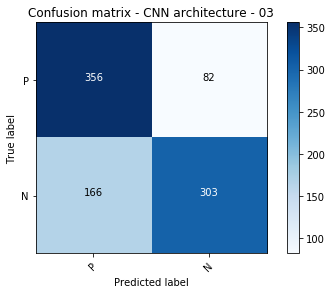

In [97]:
from sklearn.metrics import confusion_matrix
#Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_2)
np.set_printoptions(precision=2)

pltpy.figure()
plot_confusion_matrix(cnf_matrix, classes="PN",
                      title='Confusion matrix - CNN architecture - 03')